[//]: # (Image References)

[image1]: https://user-images.githubusercontent.com/10624937/43851024-320ba930-9aff-11e8-8493-ee547c6af349.gif "Trained Agent"

# Continuous Control

---

In this notebook, you will see a Policy Gradient approach in action learning to move a mechanical arm to reach a given target location. This was part of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

![Trained Agent][image1]

## 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from collections import deque

import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
from unityagents import UnityEnvironment

from ddpg_agent import Agent

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
env = UnityEnvironment(file_name='Reacher_Linux/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

## 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=False)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


## 3. Learning stage

Along the same line of though that we discussed in our [previous project](https://github.com/escorciav/drlnd-navigation/blob/master/Navigation.ipynb), we are interested on aiding our agent, a robotic arm, to learn through experiences to reach a target location. Last time, we revisited the famous DQN algorithm that learns to play Atari at a human performance level by itself. However, this algorithm is a bit limited for our _Reacher_ project. In this case our action space is continous, thus it's more natural to focus on the way that actions are taken.

_Why would we do that?_

In the case of DQN, we rely on finding the action that maximizes an action-value function. This maximization could be too difficult in a continuous space with infinite possible values. Moreover, there are cases in which it's simpler to come up with a way to react or reason about a plausible action instead of constructing a perfect action-value function from which we sample the actions of our agent.

OK. Sounds good. How do we do it?

In a nutshell, we will adjust a bit the architecture of our agent's brain to model the sensorimotor relationships explicitly. Wait, sensoriwhat? basically how to translate the perceptual inputs into actions. In the next sections, we will revisit the concept of policy gradients and how to adjust the DQN algorithm to incorporate the sensorimotor stream.

### 3.1 Policy Gradients

The term policy gradients correspond to a big familiy of algorithms that learn the sensorimotor relationships of any agent using gradient based methods.

_What is a policy?_

A policy is the strategy devised by our agent to take a given action from a given sensor/perceptual inputs. In other words, it is a shorter way to say sensorimotor relationships 😄. We will denote our policy as $\mu_\theta$ which corresponds to a function that transforms the current state, $s_t$, of our agent into an action $a_t$ i.e. $a_t = \mu(s_t|\theta^\mu)$ where $\theta^\mu$ corresponds to the parameters of our policy function. As you may imagine, $\theta^\mu$ will correspond to the parameters of a neural network.

In other words, policiy-based methods model the relationship between the state space and action space explictly. This is simply a conceptual step introducing a new element into our reinforcement learning problem. 

_What about the gradients?_

The gradient part comes from the fact that the parameters $\theta^\mu$ of the policy are found based on gradient evaluations of an optimization problem which we will described in the next section.
    
### 3.2 Learning

Let's remind the reinforcement learning setup, at every moment in time our agent collects information about the environment, i.e. itself and the things in front of it (the so-called state space of 33 dimensions here); and it takes action (adjusting the torque of the 4 joints forming the so-called action space). Subsequently, it will recive another packet of information, i.e. a new 33 dimensional vector; and the reward (+0.1 when the hand is at the goal location). This process will repeat for a period of time, and our agent will be able to assess if a given policy $\mu_theta$ allows it to keep the extreme of the hand at the desired location.
      
It seems that the setup has not really changed wrt the one of DQN algorithm, described [before](https://github.com/escorciav/drlnd-navigation/blob/master/Navigation.ipynb). At every time step, we could try to change the parameters, $\theta$, of our "Policy" such that get rewards often. In layman terms, we could think about our agent as having a module (or brain), which we call the Actor, that tries to associate state with actions that are associated with high rewards.

_How do we update the parameter of our Actor?_

As we mentioned before, this setup is not unfamiliar. Thus, we could still resort on the notion of the TD-Error to define how to update our policy. Assuming a experience tuple (s, a, r', s'), the TD-Error is defined as:

$L = r + \gamma Q(s', a) - Q(s, a)$

where $\gamma$ is a discount factor, and $Q$ is a state-value function. The $Q$ function assesses the relevance of the current state-action. Thus, it can help us to shape our _Actor_ module such that it's encouraged to take certain actions for a given state configuration. To do so we need to enhance our agent with a new module that approximates the Q-function, this module is commonly called a _Critic_, and it judges the actions taken by our Actor module. In practice, the _Critic_ is simply a function $Q(s, a;\theta^Q)$ which can be approximated by a neural network.

With this setup, we have all the pieces of our lego ready. Our agent is composed by two modules an _Actor_ $a = \mu(s|\theta^\mu)$ that translates the perceptual info on the environment into an action $s$ and a _Critic_ $Q(s, a|\theta^Q)$ that judges if a given state-action pair will get high reward.

The great news of keeping a similar formluation is that we can rely on previous successful ideas. In particular, the concept of (i) a _Replay Buffer_ to store experience and avoid learning correlated samples; and (ii) _soft-updates or target functions_ which avoids the drifting problem associated by updating our agent parameters with its own guess, estimates of Q, to fast.

Finally, in this particular implementation we exploit the properties of parallel computing to make use of the experiences of multiple agents using the same _Actor-Critic_ parameters ($\theta^\mu,\theta^Q$). This is a great strategy to increase the diversity of samples in our Replay Buffer.

### 3.3 Actor-Critic details

For simpliciy and modularity, all the inner details of our actor and critic networks are in this [module](https://github.com/escorciav/drlnd-continuous-control/blob/master/model.py). We used the same hyper-parameter configuration described in the [paper](https://arxiv.org/pdf/1509.02971.pdf).

For the _Actor_, we use a MLP with a single hidden layer. In practice, we project the state space into a space of 400 dimension through a Linear layer. The size of our hidden layer is 300 dimensions. Finally, our output layer projects the output of our hidden layer into the size of the action space. With the exception of the last linear projection layer, all the others are followed by a ReLU non-linearity. The last linear layer is followed by a `tanh` non-linearity ensuring that the output range fits between $[-1, 1]$ i.e. the admisible values of our actuators.

The _Critic_ network is similar to the _Actor_. The only notable differences are:

- The size of our output layer is reduced to 1 and we remove any non-lineary after it, as it is estimating the value the combined state and action pair.
    
- We fuses the state and action in the "hidden layer" of our network as presented in the [DDPG paper](https://arxiv.org/pdf/1509.02971.pdf)
    
The following figure depicts the details of our Actor adn Critic networks.

![Architecture](https://github.com/escorciav/drlnd-continuous-control/raw/master/data/diagram.png)

_Optimization and exploration and others details_

We update the target networks after each learning steps with a $\tau$ value equal to 1e-3 i.e. after each learning update our target actor-critic networks move closer to the new actor-critics networks by 0.1%. The size of our buffer is 100k experiences and the batch size is 128. The discount factor for future rewards is set 0.99.

As epxloration strategy, we use noise in the action space. In particular, the noise is sampled from [Ornstein-Uhlenbeck process](https://en.wikipedia.org/wiki/Ornstein%E2%80%93Uhlenbeck_process) with $\theta=0.15$, $\sigma=0.2$. In this way, we can add temporally-correlated noise which is of particular interest for continous problems such us our Reacher.

Here, we use the ADAM optimizer with different two learning rates 1e-4 and 1e-3, for the critic and the actor respectively. The target actor-critic networks are updated via soft-updates using $\tau=1e-3$

### 3.4 Put everything together

Now it's time to train our own agent to solve the environment!

In [5]:
random_seed = 1701
num_episodes = 1000
is_solved_score = 30
print_freq = 0.025

agent = Agent(state_size=state_size, action_size=action_size,
              random_seed=random_seed)
best_score = -1
scores_window = deque(maxlen=100)
scores_all = []
if print_freq < 1:
    print_freq = max(int(print_freq * num_episodes), 1)

for i_episode in tqdm(range(1, num_episodes + 1)):
    env_info = env.reset(train_mode=True)[brain_name]
    states = env_info.vector_observations
    scores = np.zeros(num_agents)
    
    while True:
        actions = agent.act(states)
        
        env_info = env.step(actions)[brain_name]
        next_states = env_info.vector_observations
        rewards = env_info.rewards
        dones = env_info.local_done
        agent.step(states, actions, rewards, next_states, dones)
        
        scores += env_info.rewards
        states = next_states
        if any(dones):
            break
    
    avg_score = scores.mean()
    scores_all.append(avg_score)
    scores_window.append(avg_score)
    
    if i_episode % print_freq == 0:
        print(f'Episode [{i_episode}]: score (averaged over agents) '
              f'{avg_score:.4f}')
    
    if avg_score > best_score:
        agent.save()
        best_score = avg_score
    
    if np.mean(scores_window) >= is_solved_score:
        print(f'Challenge solved after {i_episode:d} episodes')
        agent.save()
        break

  2%|▎         | 25/1000 [08:33<5:27:00, 20.12s/it]

Episode [25]: score (averaged over agents) 4.4575


  5%|▌         | 50/1000 [16:57<5:16:02, 19.96s/it]

Episode [50]: score (averaged over agents) 13.4995


  8%|▊         | 75/1000 [25:36<5:20:51, 20.81s/it]

Episode [75]: score (averaged over agents) 21.4985


 10%|█         | 100/1000 [34:19<5:19:46, 21.32s/it]

Episode [100]: score (averaged over agents) 34.1285


 12%|█▎        | 125/1000 [42:50<4:57:43, 20.42s/it]

Episode [125]: score (averaged over agents) 29.9595


 15%|█▌        | 150/1000 [51:21<4:50:07, 20.48s/it]

Episode [150]: score (averaged over agents) 33.9490


 16%|█▋        | 163/1000 [55:47<4:43:44, 20.34s/it]

Challenge solved after 164 episodes


Let's visualize the progression of our agent along the course of all the episodes

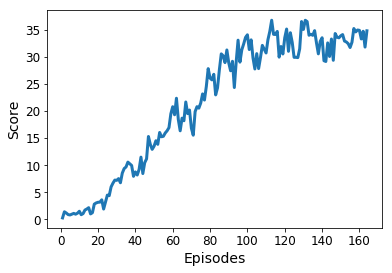

In [6]:
plt.plot(range(1, len(scores_all) + 1), scores_all,
         lw=3)
plt.xlabel('Episodes', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

## 4. Watch a smart agent

It's time to watch the performance of our autonomous agent

In [7]:
random_seed = 1701
agent = Agent(state_size=state_size, action_size=action_size,
              random_seed=random_seed)
agent.load('checkpoint.pth', map_location='cpu')

env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = agent.act(states)
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents): {}'.format(np.mean(scores)))
env.close()

Total score (averaged over agents): 35.93649919675663


## 5. Departing words

It was great to see how a simple algorithm such as DDPG managed to solved this particular continous control challenge. There are definitely more steps to improve the learning of our autonomous agents. For example,

- Prioritized experience replay. Currently, the past experiences used to train the brain is by sampling uniform random. However, we could argue that some experiences may be more "important" than others. Moreover, it is possible that such "important" experiences are infrequent and our agents ends up sampling them less often. Therefore, it would be ideal to implement a mechanism to sampling experiences in a non-uniform way based on some criterion.

- Noise in the parameteres space. To account for more exploration and possibly more robustness to unseen conditions and states, it would be important to implemente the noise in the parameters strategy dicussed [here](https://blog.openai.com/better-exploration-with-parameter-noise/).

- Other kind of algorithms. As we mentioned before the term _Policy Gradient_ corresponds to a family of methods. Thus, there are other aglorithmic formulations of the learning problem such as A2C, PPO, etc. It would be interesting to see how the difference between each other in a common challenge.